# ANÁLISIS DE TEXTO (TEXT MINING)

# Importar librerías

In [1]:
#Tratamiento de textos
import numpy as np
import pandas as pd
import string #para trabajar con cadenas de caracteres
import re # para trabajar con expresiones regulares

#Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

Vamos a importar los tweets de 3 personajes (Elon Musk, Mayor Edlee y Bill Gates) y analizarlos.

# Instalar paquete NLTK desde anaconda

In [2]:
from sklearn import svm
from sklearn.model_selection import train_test_split

#GridSearchCV se usa para validación cruzada 
#(Coger el 80% de entrenamiento varias veces con parámetros diferentes para ver las soluciones y quedarnos con el mejor resultado)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#TF-IDF Vectorizer (Term Frequency-Inverse Document Frecuency Vectorizer)
from sklearn.feature_extraction.text import TfidfVectorizer

#kit de herramientas de lenguaje natural
import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords

#Configuración warnings
import warnings
warnings.filterwarnings("ignore")

GridSearchCV es una técnica de búsqueda exhaustiva utilizada para encontrar la mejor combinación de hiperparámetros de un modelo de aprendizaje automático mediante la evaluación del rendimiento del modelo en diferentes combinaciones utilizando validación cruzada. Esto ayuda a ajustar y optimizar los modelos para obtener un mejor rendimiento en conjuntos de datos específicos.

TfidfVectorizer: expresa la relevancia de una palabra en el documento.

Es una clase de scikit-learn que convierte documentos de texto en una matriz numérica utilizando la medida TF-IDF. Esta representación se utiliza para analizar y modelar datos de texto en tareas de aprendizaje automático.

Las "stopwords" (palabras vacías o de parada) son palabras comunes que se consideran irrelevantes para el análisis de texto debido a su alta frecuencia de aparición en un lenguaje determinado. Estas palabras incluyen artículos, preposiciones, conjunciones y pronombres, entre otros términos muy frecuentes pero que aportan poco valor semántico al texto.

# Lectura de datos

In [3]:
tweets_elon = pd.read_csv("datos_tweets_@elonmusk.csv")
tweets_edlee = pd.read_csv("datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv("datos_tweets_@BillGates.csv")

In [4]:
tweets_elon.shape #número de filas y columnas

(2678, 35)

In [5]:
tweets_elon.head(2) #las dos primeras filas

,screen_name,user_id,created_at,status_id,text,retweet_count,favorite_count,is_quote_status,quote_status_id,is_retweet,...,hashtags,coordinates,place_id,place_type,place_name,place_full_name,country_code,country,bounding_box_coordinates,bounding_box_type
0,elonmusk,44196397,2017-11-09T17:28:57Z,9.286758e+17,"""If one day, my words are against science, cho...",49919,104722,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,elonmusk,44196397,2017-11-09T17:12:46Z,9.286717e+17,I placed the flowers\r\n\r\nThree broken ribs\...,5940,33725,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Vamos a juntar todos los dataframes en uno solo para hacer las comparativas
tweets= pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

Cuando se utiliza ignore_index=True en la función concat(), se indica que se deben ignorar los índices existentes de los objetos que se están concatenando y se debe generar un nuevo índice secuencial para el resultado final. Esto significa que los índices originales se descartan y se crean nuevos índices numéricos desde cero.

In [7]:
tweets.head(2)

,screen_name,user_id,created_at,status_id,text,retweet_count,favorite_count,is_quote_status,quote_status_id,is_retweet,...,hashtags,coordinates,place_id,place_type,place_name,place_full_name,country_code,country,bounding_box_coordinates,bounding_box_type
0,elonmusk,44196397,2017-11-09T17:28:57Z,9.286758e+17,"""If one day, my words are against science, cho...",49919,104722,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,elonmusk,44196397,2017-11-09T17:12:46Z,9.286717e+17,I placed the flowers\r\n\r\nThree broken ribs\...,5940,33725,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Se seleccionan y renombran las columnas de interés
#cogemos las 4 columnas que nos interesan
tweets = tweets[["screen_name", "created_at", "status_id", "text"]] 
 #cambio el nombre de esas columnas
tweets.columns = ["autor", "fecha", "id", "texto"]
tweets.head(2)

,autor,fecha,id,texto
0,elonmusk,2017-11-09T17:28:57Z,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09T17:12:46Z,9.286717e+17,I placed the flowers\r\n\r\nThree broken ribs\...


In [9]:
type(tweets["fecha"][0]) #he escogido la fecha de la primera línea y veo que es un str. Habrá que pasarlo a formato fecha

str

In [10]:
#Pasar las fechas que son str a formato fecha
tweets["fecha"] = pd.to_datetime(tweets["fecha"])
tweets.head(2)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\r\n\r\nThree broken ribs\...


In [11]:
type(tweets["fecha"][0]) #Comprobar que está en formato tipo fecha.

pandas._libs.tslibs.timestamps.Timestamp

# Trabajando con fechas

In [12]:
#Pueden haber iniciado la actividad en distintas épocas. Es interesante explorar los tweets que se solapan en el tiempo.
#Hacemos un dataframe copy para practicar y verlo
df_tempo = tweets.copy()
df_tempo.head(2)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\r\n\r\nThree broken ribs\...


In [13]:
#Cuántos tweets ha trabajado cada uno de ellos por meses. 
#Cojo el dato, lo paso a str con año y mes (todos pondrá como día 1) y luego lo vuelvo a pasar a fecha
df_tempo["fecha"] = pd.to_datetime(df_tempo["fecha"].dt.strftime("%Y-%m"))
df_tempo.head(2)

,autor,fecha,id,texto
0,elonmusk,2017-11-01,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-01,9.286717e+17,I placed the flowers\r\n\r\nThree broken ribs\...


Esta línea de código convierte las fechas en formato "AAAA-MM-DD" a formato "AAAA-MM" (año-mes) y actualiza la columna "fecha" del DataFrame df_tempo con las fechas convertidas. Esto puede ser útil cuando se desea agrupar o realizar análisis por mes, ignorando los días específicos.

In [14]:
# Vamos a agrupar los datos por fechas
#Al agrupar los datos de varias filas en una, hay que decidir qué valor poner "size"
#size nos da el número de filas/elementos de cada grupo (agrupado por meses)
df_temp2= df_tempo.groupby(df_tempo["fecha"]).size() #nos da los número de tweets por mes
df_temp2

fecha
2011-09-01      1
2011-10-01     15
2011-11-01     15
2011-12-01      3
2012-01-01     32
             ... 
2017-07-01    277
2017-08-01    297
2017-09-01    209
2017-10-01    252
2017-11-01     54
Length: 75, dtype: int64

groupby() de pandas en el DataFrame df_tempo para agrupar los datos por los valores únicos de la columna "fecha". Esto significa que los datos se agruparán según los distintos meses presentes en la columna "fecha".

.size(): Se aplica el método .size() después del groupby() para obtener el tamaño de cada grupo. Esto cuenta el número de ocurrencias de cada mes y devuelve una serie que muestra el número de tweets correspondientes a cada mes.

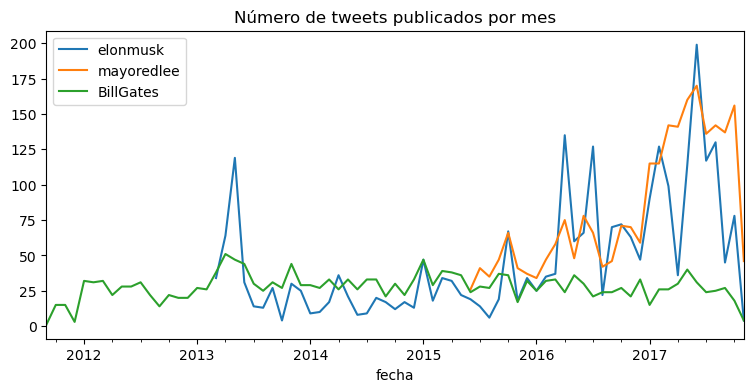

In [15]:
#Vamos a volver a la variable inicial y hacer un plot
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets["autor"] == autor].copy()
    df_temp["fecha"] = pd.to_datetime(df_temp["fecha"].dt.strftime("%Y-%m"))
    df_temp= df_temp.groupby(df_temp["fecha"]).size()
    df_temp.plot(label=autor, ax=ax)
    
ax.set_title("Número de tweets publicados por mes")
ax.legend();

El código que proporcionas utiliza la biblioteca Matplotlib en Python para crear una visualización de la cantidad de tweets publicados por mes para diferentes autores. Aquí se explica qué sucede en el código:

1. `fig, ax = plt.subplots(figsize=(9,4))`: Se crea una figura y un conjunto de ejes utilizando la función `plt.subplots()`. Se especifica el tamaño de la figura con `figsize=(9,4)`, donde el primer valor es el ancho y el segundo valor es la altura.

2. El bucle `for autor in tweets.autor.unique():` itera sobre los autores únicos en la columna "autor" del DataFrame "tweets".

3. `df_temp = tweets[tweets["autor"] == autor].copy()`: Se crea una copia del DataFrame "tweets" donde se filtran solo los tweets del autor actual en cada iteración del bucle.

4. `df_temp["fecha"] = pd.to_datetime(df_temp["fecha"].dt.strftime("%Y-%m"))`: Se convierte la columna "fecha" del DataFrame "df_temp" al formato de fecha utilizando `pd.to_datetime()`, de manera similar a lo explicado anteriormente.

5. `df_temp = df_temp.groupby(df_temp["fecha"]).size()`: Se agrupan los datos de "df_temp" por mes y se cuentan los tweets por mes utilizando `.groupby()` y `.size()`, similar a lo mencionado anteriormente.

6. `df_temp.plot(label=autor, ax=ax)`: Se traza el gráfico de línea para el autor actual utilizando el método `plot()` de pandas en el DataFrame "df_temp". Se especifica la etiqueta del autor utilizando el parámetro `label` y se proporciona el conjunto de ejes `ax` creado anteriormente.

7. `ax.set_title("Número de tweets publicados por mes")`: Se establece el título del gráfico utilizando el método `set_title()` en el conjunto de ejes `ax`.

8. `ax.legend()`: Se muestra la leyenda en el gráfico para identificar los diferentes autores utilizando el método `legend()` en el conjunto de ejes `ax`.

En resumen, el código crea un gráfico de línea que muestra la cantidad de tweets publicados por mes para diferentes autores, utilizando la biblioteca Matplotlib. Cada autor se representa en una línea diferente en el gráfico y se muestra una leyenda para identificar los autores. El título del gráfico indica el tema de los datos visualizados.

# Limpieza y tokenización

LIMPIEZA: 
Eliminar todo aquello que no aporte información, p.e: URLs, signos de puntuación, etiquetas HTML, caracteres sueltos y números.

TOKENIZACIÓN: 
Se divide el texto en unidades (palabras).

VAMOS A CREAR UNA FUNCIÓN PARA LIMPIEZA Y TOKENIZACIÓN

In [16]:
def limpiar_tokenizar(texto):
    #El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    #Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    #Elimianción de las páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub("http\S+", " ", nuevo_texto)
    #Eliminación de los signos de puntuación
    regex ='[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\]\\^\\_\\`\\{\\|\\}\\~\\…]'
    nuevo_texto = re.sub(regex, " ", nuevo_texto)
    #Eliminación de números
    nuevo_texto = re.sub("\d+", " ", nuevo_texto)
    #Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", " ", nuevo_texto)
    #Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep= " ")
    # ELiminación de tokens con una longitud <2
    nuevo_texto = [token for token in nuevo_texto if len(token) >1]
    
    return(nuevo_texto)

La función re.sub() busca todas las ocurrencias del patrón en la cadena de texto y las reemplaza con la cadena de reemplazo especificada. Devuelve una nueva cadena con las sustituciones realizadas.

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

EXISTE UNA FUNCIÓN QUE HACE ESTE TRABAJO, PERO PARA IR ENTENDIENDO CÓMO TRABAJA

La función `limpiar_tokenizar(texto)` recibe una cadena de texto como entrada y realiza una serie de operaciones para limpiar y tokenizar el texto. A continuación se explica paso a paso qué sucede en cada línea de código:

1. `nuevo_texto = texto.lower()`: Se convierte todo el texto a minúsculas utilizando el método `lower()`. Esto ayuda a estandarizar el texto y tratar las palabras en minúsculas.

2. `nuevo_texto = re.sub("http\S+", " ", nuevo_texto)`: Se utiliza la función `re.sub()` para eliminar las URL presentes en el texto. El patrón `"http\S+"` busca cualquier cadena que comience con "http" y esté seguida por uno o más caracteres que no sean espacios en blanco (`\S+`). Estas URLs se reemplazan por un espacio en blanco.

3. `regex = "[\\!\\\"\\#\\$\\%\\&\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\\\]\\^\\_\\`\\{\\|\\}\\~\\'\\]"`: Se define una expresión regular en forma de cadena para representar un conjunto de caracteres especiales y de puntuación que se desea eliminar del texto.

4. `nuevo_texto = re.sub(regex, " ", nuevo_texto)`: Se utiliza la función `re.sub()` nuevamente para eliminar todos los caracteres especiales y de puntuación definidos en la expresión regular. Estos caracteres se reemplazan por un espacio en blanco.

5. `nuevo_texto = re.sub("\d+", " ", nuevo_texto)`: Se utiliza `re.sub()` para eliminar cualquier número presente en el texto. El patrón `"\d+"` busca una o más ocurrencias de dígitos. Estos números se reemplazan por un espacio en blanco.

6. `nuevo_texto = re.sub("\\s+", " ", nuevo_texto)`: Se utiliza `re.sub()` para reemplazar cualquier secuencia de espacios en blanco por un solo espacio en blanco. Esto ayuda a normalizar los espacios en el texto.

7. `nuevo_texto = nuevo_texto.split(sep=" ")`: Se divide el texto en palabras individuales utilizando el método `split()` y se utiliza un espacio en blanco como separador. Esto crea una lista de palabras.

8. `nuevo_texto = [token for token in nuevo_texto if len(token) > 1]`: Se aplica una comprensión de lista para filtrar las palabras de la lista `nuevo_texto`. Solo se conservan aquellos tokens (palabras) que tienen una longitud mayor que 1. Esto ayuda a eliminar posibles caracteres no deseados o palabras de un solo carácter.

[token for token in nuevo_texto if len(token) > 1]: Esta es la estructura de la comprensión de lista. Significa que se va a crear una nueva lista que contendrá cada elemento token de la lista nuevo_texto que cumpla la condición len(token) > 1.

9. `return(nuevo_texto)`: La función devuelve la lista de palabras resultante.

En resumen, la función `limpiar_tokenizar(texto)` toma un texto como entrada, lo limpia mediante la eliminación de URLs, caracteres especiales, puntuación y números, y luego lo tokeniza dividiéndolo en palabras individuales. El resultado es una lista de palabras limpias y tokenizadas.

In [18]:
txtTK= limpiar_tokenizar(df_tempo["texto"][1])
txtTK                                 

['placed',
 'the',
 'flowers',
 'three',
 'broken',
 'ribs',
 'pierced',
 'lung',
 'and',
 'still',
 'he',
 'fought',
 'for',
 'peace',
 'at']

In [19]:
test = "Esto es 1 ejemplo de l'limpieza de3 m TEXTO https://igeldo.com"
test1 = "@datamining #textmining 45% clean!"
test = test + test1
print(test)
print(limpiar_tokenizar(test))

Esto es 1 ejemplo de l'limpieza de3 m TEXTO https://igeldo.com@datamining #textmining 45% clean!
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'textmining', 'clean']


# EJERCICIO

Hacer una función llamada "limpiaYtokeniza" que limpie y "tokenize" texto, utilizando un tokenizador de NLTK. Investigar cómo funciona.

In [20]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import punkt

def limpiaYtokeniza(test):
    nuevo_test = test.lower() #convertir a minúsculas
    nuevo_test = re.sub("http\S+", " ", nuevo_test)
    nuevo_test = re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ]', ' ', nuevo_test)
    tokens = word_tokenize(nuevo_test) #tokenizar 
    stopwords_es = set(stopwords.words('spanish'))
    stopwords_en = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords_es and token not in stopwords_en]
    nuevo_test = [token for token in tokens if len(token) >1]
    return nuevo_test

Explicación de la nueva función creada limpiaYtokeniza:
1. `from nltk.tokenize import word_tokenize`: Se importa la función `word_tokenize` del módulo `nltk.tokenize`. Esta función se utiliza para tokenizar el texto en palabras individuales.

2. `import nltk`: Se importa el módulo `nltk`, que proporciona diversas funciones y recursos para el procesamiento del lenguaje natural.

3. `from nltk.corpus import stopwords`: Se importa el corpus de palabras de parada (stopwords) del módulo `nltk.corpus`. Las palabras de parada son palabras comunes que suelen filtrarse durante el procesamiento del texto, ya que no aportan mucha información.

4. `import re`: Se importa el módulo `re`, que proporciona funciones para trabajar con expresiones regulares.

5. `limpiaYtokeniza(texto)`: Esta es la función principal. Recibe un parámetro `texto` que representa el texto a limpiar y tokenizar.

6. `nuevo_texto = texto.lower()`: Se convierte el texto a minúsculas utilizando el método `lower()`. Esto ayuda a normalizar el texto y evitar discrepancias en las palabras en mayúsculas y minúsculas.

7. `nuevo_texto = re.sub("http\S+", " ", nuevo_texto)`: Se utiliza la función `re.sub()` para eliminar cualquier URL del texto. La expresión regular `"http\S+"` coincide con cualquier cadena que comienza con "http" y está seguida por cualquier carácter que no sea un espacio en blanco. Se reemplaza por un espacio en blanco.

8. `nuevo_texto = re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ]', ' ', nuevo_texto)`: Se utiliza `re.sub()` para eliminar todos los caracteres no alfabéticos del texto. La expresión regular `r'[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ]'` coincide con cualquier carácter que no sea una letra alfabética o una letra acentuada en español. Se reemplaza por un espacio en blanco.

9. `tokens = word_tokenize(nuevo_texto)`: Se utiliza la función `word_tokenize()` para tokenizar el texto en palabras individuales. Esto divide el texto en una lista de tokens (palabras).

10. `stopwords_es = set(stop








In [21]:
test = "Esto es 1 ejemplo de l'limpieza de3 m TEXTO https://igeldo.com if is correct" 
test1 = "@datamining #textmining 45% clean!"
test = test + test1
print(test)
print(limpiaYtokeniza(test))

Esto es 1 ejemplo de l'limpieza de3 m TEXTO https://igeldo.com if is correct@datamining #textmining 45% clean!
['ejemplo', 'limpieza', 'texto', 'correct', 'datamining', 'textmining', 'clean']


In [22]:
stop_words = set(stopwords.words('spanish')) #Estas son las palabras que elimina en español
stop_words

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

# Aplicar la función de limpiar_tokenizar a los tweets de nuestro dataframe

In [23]:
# Aplicar la función de limpieza y tokenizacióna cada tweet
# apply: para aplicar la función a la columna (en este caso, la de limpiar tokenizar)
# lambda para funciones muy sencillas
#estructura: lambda x: código, siendo x el/los parámetro/s de entrada
tweets["texto_tokenizado"] = tweets["texto"].apply(lambda x: limpiar_tokenizar(x))
tweets[["texto", "texto_tokenizado"]].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\r\n\r\nThree broken ribs\...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


En el código proporcionado, se realiza una operación de limpieza y tokenización del texto en la columna "texto" de un DataFrame llamado "tweets". El resultado se almacena en una nueva columna llamada "texto_tokenizado". Veamos la explicación paso a paso:

1. `tweets["texto_tokenizado"] = tweets["texto"].apply(lambda x: limpiar_tokenizar(x))`: Se crea una nueva columna llamada "texto_tokenizado" en el DataFrame "tweets". La columna se rellena aplicando una función a cada valor de la columna "texto". La función utilizada se define mediante `lambda x: limpiar_tokenizar(x)`. Esto significa que para cada valor `x` en la columna "texto", se llama a la función `limpiar_tokenizar(x)` para realizar la limpieza y tokenización del texto.

2. `tweets[["texto", "texto_tokenizado"]].head()`: Se seleccionan las columnas "texto" y "texto_tokenizado" del DataFrame "tweets" utilizando la notación de corchetes y se muestra el resultado utilizando el método `head()`. Esto mostrará las primeras filas del DataFrame con las columnas "texto" original y "texto_tokenizado" resultante.

En resumen, el código aplica la función `limpiar_tokenizar` a cada valor de la columna "texto" del DataFrame "tweets", crea una nueva columna "texto_tokenizado" con el resultado y muestra las primeras filas del DataFrame con las columnas original y tokenizada.

# Expansión o unnest

Antes de dividir el texto en palabras. Tenemos en cada fila todo su texto, pero al tokenizar tenemos una lista de palabras, es un array.

Ahora el elemento de estudio no es la frase, sino cada palabra. Este proceso se llama expansión o unnest. Se facilita la actividad de agrupación, gráficos, contar...

In [24]:
tweets_tidy = tweets.explode(column="texto_tokenizado")
tweets_tidy.head(3)

,autor,fecha,id,texto,texto_tokenizado
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho...",if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho...",one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho...",day


In [25]:
tweets_tidy.shape

(106874, 5)

In [26]:
tweets_tidy = tweets_tidy.drop(columns="texto") #elimiar la columna texto
tweets_tidy = tweets_tidy.rename(columns={"texto_tokenizado":"token"}) #otra forma de renovar columnas
tweets_tidy.head(3) #el mismo tweet tendrá el mismo id

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


Para entender qué caracteriza la escritura de cada autor, vamos a estudiar sus palabras.

In [27]:
tweets_tidy.groupby("autor")["token"].count() #agrupando por autor contamos palabras de la columna token

autor
BillGates     31513
elonmusk      33578
mayoredlee    41774
Name: token, dtype: int64

In [28]:
tweets_tidy.groupby("autor")["token"].nunique() #palabras totales diferentes por autor

autor
BillGates     4766
elonmusk      6551
mayoredlee    5517
Name: token, dtype: int64

In [29]:
#Calcular la longitud de los tweets teniendo en cuenta el autor y su id
temp_df = pd.DataFrame(tweets_tidy.groupby(by=["autor", "id"])["token"].count())
temp_df.head(3)

token
autor     id                 
BillGates 1.195196e+17     17
          1.213001e+17     16
          1.217459e+17     21

In [30]:
#Ahora podemos sacar la longitud media y la desviación de cada tweet por autor
temp_df.groupby("autor")["token"].agg(["mean", "std"])

,mean,std
autor,,
BillGates,15.150481,3.348156
elonmusk,12.599625,6.923537
mayoredlee,17.127511,3.468914


# EJERCICIO 

OBTENER Y MOSTRAR EN FORMA DE TABLA LAS 5 PALABRAS MÁS UTILIZADAS POR CADA AUTOR

In [31]:
tweets_tidy.groupby(["autor","token"])["token"].count().reset_index(name="count").groupby("autor").apply(lambda x: x.sort_values("count", ascending=False).head(5))

autor token  count
autor                                    
BillGates  4134    BillGates   the   1180
           4207    BillGates    to   1115
           2886    BillGates    of    670
           2057    BillGates    in    590
           2175    BillGates    is    453
elonmusk   10552    elonmusk   the    985
           10665    elonmusk    to    916
           8734     elonmusk    of    638
           7692     elonmusk    is    543
           7550     elonmusk    in    478
mayoredlee 16265  mayoredlee    to   1693
           16190  mayoredlee   the   1355
           11499  mayoredlee   amp   1212
           14637  mayoredlee   our   1104
           15606  mayoredlee    sf    911

En el código proporcionado se realiza una serie de operaciones utilizando el DataFrame "tweets_tidy". A continuación se explica el código paso a paso:

tweets_tidy.groupby(["autor", "token"])["token"].count().reset_index(name="count").groupby("autor").apply(lambda x: x.sort_values("count", ascending=False).head(5))

1. `tweets_tidy.groupby(["autor", "token"])["token"].count()`: Se realiza una agrupación del DataFrame "tweets_tidy" por las columnas "autor" y "token". Luego se cuenta la frecuencia de cada token en cada combinación de autor y token.

2. `.reset_index(name="count")`: Se restablece el índice del DataFrame resultante y se asigna un nombre "count" a la columna que contiene la frecuencia de los tokens.

3. `.groupby("autor").apply(lambda x: x.sort_values("count", ascending=False).head(5))`: Se realiza una agrupación adicional por la columna "autor" y se aplica una función lambda a cada grupo. La función lambda ordena cada grupo en función de la columna "count" de forma descendente y luego selecciona las 5 filas con los valores más altos de "count" (es decir, las 5 palabras más utilizadas).

El resultado final es un DataFrame que contiene las 5 palabras más utilizadas por cada autor, ordenadas por su frecuencia.

En resumen, el código realiza operaciones de agrupación, conteo y ordenamiento en el DataFrame "tweets_tidy" para obtener las 5 palabras más utilizadas por cada autor.

# Stopwords

Estas palabras no nos aportan ninguna información. 

In [32]:
#Vamos a quitar esas palabras del dataset

In [33]:
nltk.download("stopwords") # Aunque importas la librería hay que hacer el .download()
stop_words = list(stopwords.words("english"))
#se añade la stopword: amp, ex
stop_words.extend(("amp", "ex")) # podemos extender la lista de stopwords: en este caso hemos añadido "amp" y "ex"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\72478072N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
print(stop_words[60:80])

['a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into']


# Eliminar Stopwords

In [35]:
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


In [36]:
# Filtrado para excluir stopwords  /// tweets_tidy_sw -> Sin los stopwords
# ~x -> not x , significa que no es lo que viene despues
tweets_tidy_sw = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))] # aunque nombramos columan trabjamos con filas
tweets_tidy_sw.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,words


In [37]:
# Vamos a buscar el "top10". Ahora que hemos eleiminado los stopwords...

In [38]:
df_temp1 = tweets_tidy_sw[tweets_tidy_sw.autor == "BillGates"]
h10 = df_temp1["token"].head(10)
h10 # llamamos al h10

5125     tanzania
5125        hopes
5125    eliminate
5125          one
5125      world’s
5125      painful
5125     diseases
5125          saw
5125      village
5125          i’m
Name: token, dtype: object

In [39]:
counts1 = df_temp1["token"].value_counts(ascending = False).head(10)
counts1

great     216
one       146
world     143
people    140
new       120
help      113
polio     102
lives     101
energy     97
via        92
Name: token, dtype: int64

In [40]:
# por autor

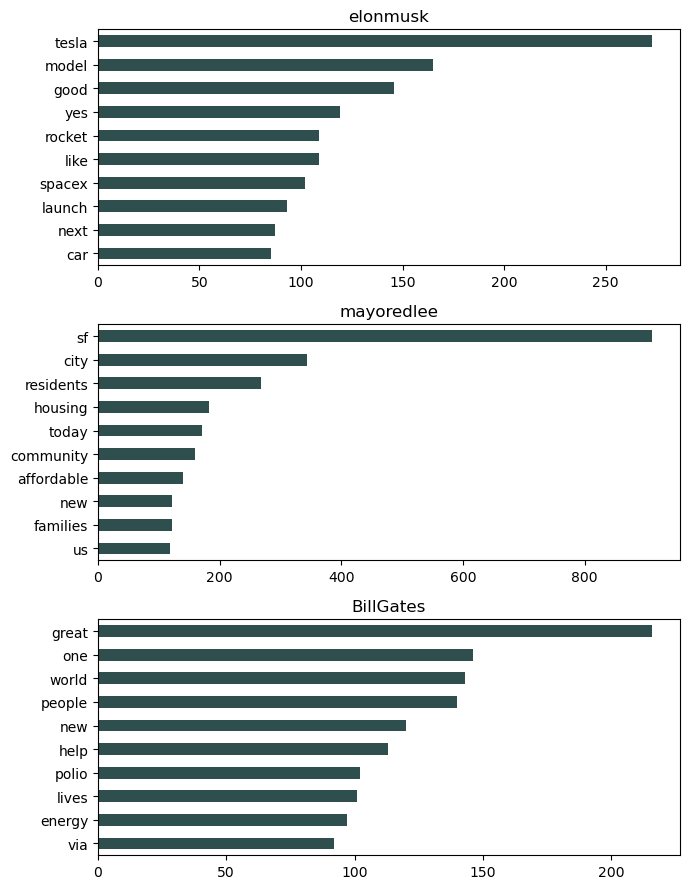

In [41]:
# Top 10 palabras por autor (sin stipwords)
# =========================================
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (7, 9))
for i, autor in enumerate(tweets_tidy_sw.autor.unique()):
    df_temp = tweets_tidy_sw[tweets_tidy_sw.autor == autor]
    counts = df_temp["token"].value_counts(ascending = False).head(10)
    counts.plot(kind = "barh", color = "darkslategray", ax = axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

# Term Frequency (tf) y Inverse Document Frecuency (idf)

Vamos a ponderar las palabras respecto al grado de su relevancia. Si aparace en pocos tweets la palabra se le da mayor peso que las que aparecen muchas veces.

Para ello disponemos de la clase TfidfVectorizer de Scikit Learn

# Clasificación de tweets

Vamos a crear un modelo de machine learning basado en en màqiomad de vector soporte (SVM)

In [42]:
# Dataos de entrenamiiento y test
# Cogemos las filas de "elonmusk", "mayoredlee"
datos_X = tweets.loc[tweets.autor.isin(["elonmusk", "mayoredlee"]), "texto"] # de los tweets (files) con autores em y mel cogemos coulumna texto # Varaiable predictora
datos_y = tweets.loc[tweets.autor.isin(["elonmusk", "mayoredlee"]), "autor"]

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 224
)

In [43]:
# Creación de la matriz tf-idf
# min_df es el mínimo número de c

vectorizador_tfidf = TfidfVectorizer( 
                        min_df      = 3,
                        stop_words  = stop_words
                    )
# fit: learn vocabulary and idf from training set
vectorizador_tfidf.fit(X_train) # es un pseudo-modelo, (No es un modelo todavía) le estamos metiendo un monton de tweets de entrenamiento

TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [44]:
tfidf_train = vectorizador_tfidf.transform(X_train) # metemos los tweets tokenizdos, limpios y ponderados !!!!!!!!!
tfidf_test  = vectorizador_tfidf.transform(X_test)

# Creamos Modelo SVM lineal

In [45]:
modelo = svm.SVC(kernel = "linear")
modelo.fit(X = tfidf_train, y = y_train)

SVC(kernel='linear')

# vamos a validar el modelo con tfidf_test/y_test

In [46]:
tfidf_test.shape

(1025, 2800)

In [47]:
modelo.score(tfidf_test, y_test)

0.9736585365853658

In [48]:
y_pred = modelo.predict(tfidf_test) # Esta es la PREDICCIÓN
y_pred[:13]

array(['elonmusk', 'mayoredlee', 'mayoredlee', 'mayoredlee', 'mayoredlee',
       'elonmusk', 'elonmusk', 'mayoredlee', 'elonmusk', 'mayoredlee',
       'mayoredlee', 'mayoredlee', 'elonmusk'], dtype=object)

In [49]:
y_test.values[:13] # Esta es la REALIDAD

array(['elonmusk', 'mayoredlee', 'mayoredlee', 'mayoredlee', 'mayoredlee',
       'elonmusk', 'elonmusk', 'mayoredlee', 'elonmusk', 'mayoredlee',
       'elonmusk', 'mayoredlee', 'elonmusk'], dtype=object)

# EJERCICIO 1

In [50]:
# Dataos de entrenamiiento y test
# Cogemos las filas de "elonmusk", "mayoredlee"
datos_X = tweets.loc[tweets.autor.isin(["elonmusk", "BillGates"]), "texto"] # de los tweets (files) con autores em y mel cogemos coulumna texto # Varaiable predictora
datos_y = tweets.loc[tweets.autor.isin(["elonmusk", "BillGates"]), "autor"] # Es lo que queremos PREDECIR

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 224
)

In [51]:
# Creación de la matriz tf-idf
# min_df es el mínimo número de c

vectorizador_tfidf = TfidfVectorizer( 
                        min_df      = 3,
                        stop_words  = stop_words
                    )
# fit: learn vocabulary and idf from training set
vectorizador_tfidf.fit(X_train) # es un pseudo-modelo, (No es un modelo todavía) le estamos metiendo un monton de tweets de entrenamiento

TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [52]:
tfidf_train = vectorizador_tfidf.transform(X_train) # metemos los tweets tokenizdos, limpios y ponderados !!!!!!!!!
tfidf_test  = vectorizador_tfidf.transform(X_test)

In [67]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = svm.SVC(kernel = "poly", degree=2) #vamos a usar una aproximación de grado 3 (x al cubo)
poly_reg.fit(tfidf_train, y_train)


SVC(degree=2, kernel='poly')

In [68]:
poly_reg.score(tfidf_test, y_test)

0.9433368310598111

In [69]:
y_pred = modelo.predict(tfidf_test) # Esta es la PREDICCIÓN
y_pred[:13]

ValueError: X has 2391 features, but SVC is expecting 2800 features as input.

In [70]:
y_test.values[:13] # Esta es la REALIDAD

array(['BillGates', 'BillGates', 'elonmusk', 'elonmusk', 'elonmusk',
       'elonmusk', 'BillGates', 'BillGates', 'elonmusk', 'elonmusk',
       'BillGates', 'BillGates', 'BillGates'], dtype=object)

In [78]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
degrees = [1, 2, 3]

for degree in degrees:
    model = SVC(kernel = "poly", degree = degree)
    model.fit(tfdft_train, y1_train)
    accurac = _model.score(tfdf_test, y_test)
    print(f"Grado = {degree}, Preccisión = {accuracy}")

NameError: name 'tfdft_train' is not defined